In [1]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import cv2
import math
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import torchvision
import torch.nn as nn
import torch.optim as optim
from skimage import io
import skimage
import openslide
from torch.optim import lr_scheduler, Adam, SGD
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
!pip install imagecodecs
# !pip uninstall tifffile

     |████████████████████████████████| 17.9 MB 2.4 MB/s eta 0:00:01


In [3]:
BASE_PATH='../input/prostate-cancer-grade-assessment/'
TRAIN_IMAGES_PATH = BASE_PATH + 'train_images/'
TRAIN_LABELS_PATH = BASE_PATH + 'train_label_masks/'
TEST_IMAGES_PATH = BASE_PATH+'test_images'
SAMPLE = BASE_PATH+'sample_submission.csv'
TRAIN=BASE_PATH+'train.csv'
TEST = BASE_PATH+'test.csv'

train_df = pd.read_csv(TRAIN)
train = train_df.copy()
test_df = pd.read_csv(TEST)
test = test_df.copy()

In [4]:
masks=os.listdir(BASE_PATH+'train_label_masks/')
images=os.listdir(BASE_PATH+'train_images/')
df_masks=pd.Series(masks).to_frame()
df_masks.columns=['mask_file_name']
df_masks['image_id']=df_masks.mask_file_name.apply(lambda x:x.split('_')[0])
df_train=pd.merge(train,df_masks,on='image_id',how='outer')
del df_masks

In [5]:
gleason_replace_dict = {0:0, 1:1, 3:2, 4:3, 5:4}

def process_gleason(gleason):
    if gleason == 'negative': gs = (1, 1)
    else: gs = tuple(gleason.split('+'))
    return [gleason_replace_dict[int(g)] for g in gs]

df_train.gleason_score = df_train.gleason_score.apply(process_gleason)

In [6]:
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,mask_file_name
0,0005f7aaab2800f6170c399693a96917,karolinska,0,"[0, 0]",0005f7aaab2800f6170c399693a96917_mask.tiff
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,"[0, 0]",000920ad0b612851f8e01bcc880d9b3d_mask.tiff
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,"[3, 3]",0018ae58b01bdadc8e347995b69f99aa_mask.tiff
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,"[3, 3]",001c62abd11fa4b57bf7a6c603a11bb9_mask.tiff
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,"[0, 0]",001d865e65ef5d2579c190a0e0350d8f_mask.tiff


In [7]:
df_train['gleason_primary'] = ''
df_train['gleason_secondary'] = ''

for idx in range(0, len(df_train.gleason_score)):
    df_train['gleason_primary'][idx] = df_train['gleason_score'][idx][0]
    df_train['gleason_secondary'][idx] = df_train['gleason_score'][idx][1]
    
df_train = df_train.drop(['gleason_score'], axis=1)
# df_train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
df_train.head()

,image_id,data_provider,isup_grade,mask_file_name,gleason_primary,gleason_secondary
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0005f7aaab2800f6170c399693a96917_mask.tiff,0,0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,000920ad0b612851f8e01bcc880d9b3d_mask.tiff,0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,0018ae58b01bdadc8e347995b69f99aa_mask.tiff,3,3
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,001c62abd11fa4b57bf7a6c603a11bb9_mask.tiff,3,3
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,001d865e65ef5d2579c190a0e0350d8f_mask.tiff,0,0


## Removing mask values

In [9]:
df_train['mask_file_name'].isnull().sum()

100

In [10]:
df_train.dropna(subset=['mask_file_name'], inplace=True, axis=0)

In [11]:
df_train.head()

,image_id,data_provider,isup_grade,mask_file_name,gleason_primary,gleason_secondary
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0005f7aaab2800f6170c399693a96917_mask.tiff,0,0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,000920ad0b612851f8e01bcc880d9b3d_mask.tiff,0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,0018ae58b01bdadc8e347995b69f99aa_mask.tiff,3,3
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,001c62abd11fa4b57bf7a6c603a11bb9_mask.tiff,3,3
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,001d865e65ef5d2579c190a0e0350d8f_mask.tiff,0,0


In [12]:
X = df_train.drop(['isup_grade'], axis=1)
Y= df_train['mask_file_name']

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X ,Y, test_size=0.2, random_state=1234)

In [14]:
def patching(img, tile_size = (224, 224), offset = (224, 224)):
    img_shape = img.shape
    patches_list = []
    for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            cropped_image = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
            cropped_img = cropped_image.astype(np.float32)
            patches_list.append(cropped_img)
#     print('make the patches and convert them to float')
    image = np.array(patches_list)
    return image 

In [15]:
# print(os.listdir("../working"))

In [16]:
# im = '../working/imagename1.bmp'
# plt.imshow(im)

In [17]:
# file_path = f'../input/prostate-cancer-grade-assessment/train_images/068b0e3be4c35ea983f77accf8351cc8.tiff'
# # file_path= f'../input/prostate-cancer-grade-assessment/train_label_masks/068b0e3be4c35ea983f77accf8351cc8_mask.tiff'
# image = skimage.io.MultiImage(file_path)[-1]
# image = cv2.resize(image, (1120, 1120))
# skimage.io.imsave("imagename1.png", image)
# plt.imshow(image)

In [18]:
# np.unique(image[:,:,0])

In [19]:
# len(np.unique(x[0]))

In [20]:
# import matplotlib
# file_path = '../working/imagename1.png'
# image = skimage.io.MultiImage(file_path)[-1]
# image = cv2.resize(image, (1120, 1120))
# x = patching(image, tile_size = (224, 224), offset = (224, 224))

# # f, ax = plt.subplots(5,5, figsize=(18,22))
# # for i in range(len(x)):
# #     ax[i//5, i%5].imshow(x[i])

In [21]:
def prePatch(file_path):
    image = skimage.io.MultiImage(file_path)[-1]
    x = patching(image, tile_size = (224, 224), offset = (224, 224))
    return x

In [22]:

class TrainDataset(Dataset):
    def __init__(self, df, labels, transform = None):
        self.df = df
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        file_name = self.df['image_id'].values[idx]
        file_name_label = self.labels.values[idx]
        file_path = f'../input/prostate-cancer-grade-assessment/train_images/{file_name}.tiff'
        file_path_label = f'../input/prostate-cancer-grade-assessment/train_label_masks/{file_name_label}'
        image = skimage.io.MultiImage(file_path)[-1]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (1120, 1120))
        skimage.io.imsave("biopsy.png", image)
#         print('image reading now moving to patching')
        image = prePatch('../working/biopsy.png')
        
        label = skimage.io.MultiImage(file_path_label)[-1]
        label = cv2.resize(label, (1120, 1120))
        skimage.io.imsave("biopsy_label.png", label)
        label = prePatch('../working/biopsy_label.png')
        
#         new_image=[]
#         new_label =[]
        
#         for i in range(len(image)):
#             if(len(np.unique(image[i]))!=1):
                
#                 new_image.append(image[i])
#                 new_label.append(label[i])
        

#         print(">> new image , new label",len(new_image), " , ", len(new_label))
#         image = np.array(new_image)
#         label = np.array(new_label)
#         print(">> new image , new label",image.shape, " , ", label.shape)
        return image, label

In [23]:
train_dataset = TrainDataset(X_train, y_train, transform= None) 
valid_dataset = TrainDataset(X_valid, y_valid, transform= None) 
train_loader = DataLoader(train_dataset, batch_size=1, num_workers = 0)
valid_loader = DataLoader(valid_dataset, batch_size=1, num_workers = 0)

In [24]:
images, classes = next(iter(train_loader))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: biopsy_label.png is a low contrast image


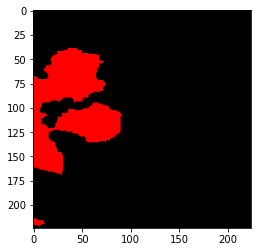

In [25]:
classes.shape
plt.imshow(classes[0][4])

In [26]:
import torch.nn.functional as F
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [27]:
model = UNet(n_channels=3, n_classes=3)

In [28]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.5)

In [29]:
def dice_loss(inputs, target):
    inputs = torch.sigmoid(inputs)
    smooth = 1.
    iflat = inputs.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    loss = 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
    return loss

In [30]:
num_epochs = 30
model.to(device)
history = []

print('Epoch has started') 

for epoch in range(num_epochs): 
    train_loss_total = 0.0 
    valid_loss_total = 0.0 
    tot = 0
    tot_train = 0
    lossV = 0
    lossL = 0
      
    for images, labels in iter(train_loader):
        for i in range(len(images)):
            
            image = images[i].to(device)
            label = labels[i].to(device) 

            image = image.type(torch.cuda.FloatTensor)
            label = label.type(torch.cuda.FloatTensor)

            image = image.permute(0,3,2,1)
            label = label.permute(0,3,2,1)

            outputs = model(image)
            loss = criterion(outputs, label) 
            loss.backward() 
            optimizer.step() 
    #       pred = (outputs > 0.5).float()
    #       lossL += dice_coeff(pred, label).item()
            lossL = dice_loss(outputs, label)
    #       tot_train += lossL.item() * data.size(0)
            train_loss_total  += loss.item()
        break

#     for datas, labels in iter(valid_loader):
#         for i in range(len(datas)):
#             data = datas[i].to(device)
#             label = labels[i].to(device)

#             data = data.type(torch.cuda.FloatTensor)
#             label = label.type(torch.cuda.FloatTensor)

#             data = data.permute(0,3,2,1)
#             label = label.permute(0,3,2,1)

#             outputs = model(data)
#             loss = criterion(outputs, label)
#     #       pred = (outputs > 0.5).float()
#     #       lossV += dice_coeff(pred, label).item()

#             lossV = dice_loss(outputs, label)
#     #       tot += lossV.item() * data.size(0)
#             valid_loss_total  += loss.item()
#         break
 
    train_loss_total_avg = train_loss_total / len(train_loader)
    valid_loss_total_avg = 0 #valid_loss_total / len(valid_loader)
    dice_train = lossL/len(train_loader)
    dice_valid = 0 #lossV/len(valid_loader)
    
    history.append([train_loss_total_avg, valid_loss_total_avg, dice_train, dice_valid]) 
    print('epoch number ', epoch, "	",'Training loss value', train_loss_total_avg , " ", 'Validation Loss Value', valid_loss_total_avg \
         , " ", 'training dice Value', dice_train, " ", 'Validation dice Value', dice_valid)
    
history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'dice_train', 'dice_valid'])  

Epoch has started


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: biopsy_label.png is a low contrast image


epoch number  0 	 Training loss value 8.006072928664007e-05   Validation Loss Value 0   training dice Value tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)   Validation dice Value 0
epoch number  1 	 Training loss value 7.588139642605712e-05   Validation Loss Value 0   training dice Value tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)   Validation dice Value 0
epoch number  2 	 Training loss value 6.966870340119642e-05   Validation Loss Value 0   training dice Value tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)   Validation dice Value 0
epoch number  3 	 Training loss value 6.335586862115138e-05   Validation Loss Value 0   training dice Value tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)   Validation dice Value 0
epoch number  4 	 Training loss value 5.6319484328634104e-05   Validation Loss Value 0   training dice Value tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)   Validation dice Value 0
epoch number  5 	 Training loss value 4.868967882

Text(0.5, 1.0, 'Training and Validation Losses')

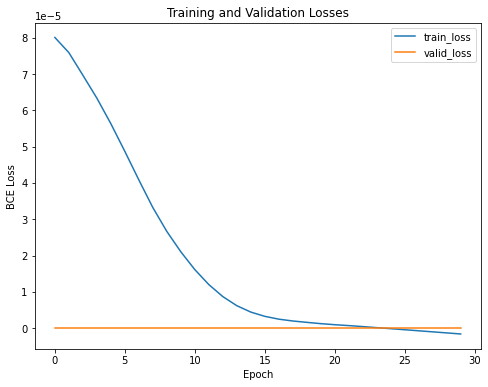

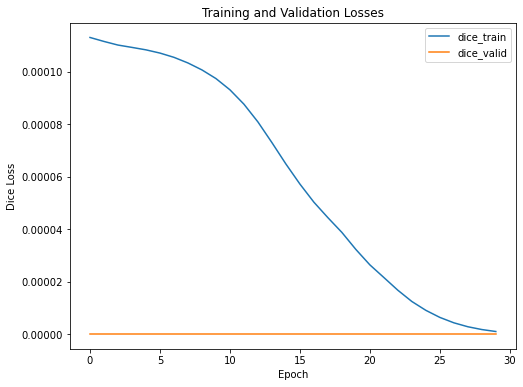

In [31]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.title('Training and Validation Losses')

plt.figure(figsize=(8, 6))
for c in ['dice_train', 'dice_valid']:
    plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.title('Training and Validation Losses')


In [ ]:
pyplot.subplot(1, 3, 1) # have two plots in 1 row two columns, first plot
# assuming im is batch x channel x h x w and channel is RGB
im, mask = next(iter(valid_loader))
pred = model(im)
pyplot.plot(im[0].detach().cpu().permute(1, 3, 0))
pyplot.subplot(1, 3, 2) # second plot
pyplot.plot(mask[0].detach().cpu())
pyplot.subplot(1, 3, 3) # third plot
pyplot.plot(pred[0].detach().cpu())